# Probability and Statistics for Ballistics

This notebook provides an overview of the probability distributions and statistical techniques used to model and analyze ballistic precision.  It leverages Monte Carlo simulations to validate and demonstrate the math.  The notebook covers the following:

1. **Normal Distribution**: Explores the Normal distribution, which models variables like muzzle velocity and shot dispersion along a single axis. It demonstrates how to estimate the mean and variance parameters from sample data, and to compute confidence intervals for these estimates.

2. **Normal Distribution in 2 Dimensions**: Extends the Normal distribution to two dimensions, which is applicable for modeling the coordinates of hits on a target. It discusses the assumptions and tests for equal variances in the horizontal and vertical directions.

3. **Rayleigh Distribution**: Introduces the Rayleigh distribution, which models the radial dispersion of shots from the center of impact when the horizontal and vertical variances are equal. It shows how to estimate the Rayleigh parameter and compute confidence intervals.

4. **Sampling Distributions**: Explains the concept of sampling distributions and how to generate them through Monte Carlo simulation. This approach is particularly useful for statistics without closed-form expressions, like Extreme Spread (a.k.a. Group Size).

5. **Statistical Tests**: Covers statistical tests for comparing the mean, variance, and/or precision of two different samples or populations. It demonstrates how to calculate *p*-values, effect sizes, and confidence intervals for these tests, and validates the results through simulations.

These techniques have been implemented for ballistic applications in [this Google Sheet](https://docs.google.com/spreadsheets/d/1i_trin4mHuTJI4HnAnPiVwJHMc0m0X09E7Ya7_aWGFQ/).

In [1]:
# Code samples depend on the following imports and helper functions
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bartlett, chi2, f, norm, percentileofscore, t

def CIstring(CI, digits: int=1):
      return np.array2string(np.array(CI), precision=digits, floatmode="fixed", separator=", ")

def cGauss(n: int) -> float:
    return math.exp(math.lgamma((n-1)/2) - math.lgamma(n/2) - math.log(math.sqrt(2/(n-1))))

## Normal Distribution in 1 dimension

The ballistic trajectory of bullets fired from the same gun at the same point have some variation from shot to shot.  We can stick a target along the trajectory to record the coordinates of each shot.  When we look at the horizontal and vertical coordinates of where each shot hits the target we find that those coordinates follow the Normal distribution.  The Normal distribution also models another variable of interest in ballistics: Muzzle velocity, which is the speed at which bullets leave the gun.

The Normal distribution has a bell curve shape that models the frequency of values that we can expect to observe from a Normal random process.  The Normal distribution is quantified by two *parameters*: mean ($\mu$), and variance ($\sigma^2$) or standard deviation ($\sigma$).  These parameters determine the peak and spread of the bell curve.  $\mathcal{N}(\mu, \sigma)$ denotes a Normal distribution with mean $\mu$ and standard deviation $\sigma$.

Following is a graph of the standard Normal distribution density $\mathcal{N}(0, 1)$, showing the frequency of values from -3 to 3.  (The tails extend to infinity in each direction, but more than 99% of values fall within $\pm 3\sigma$.)

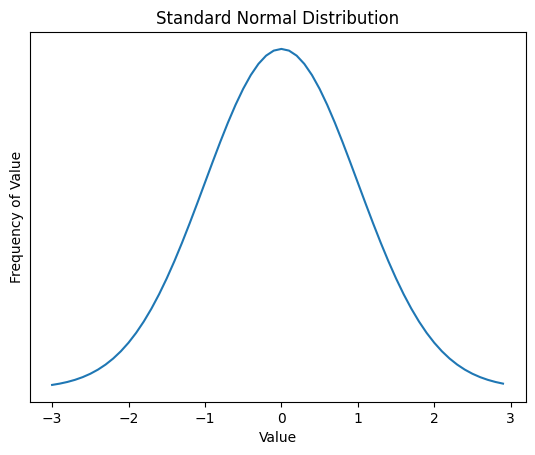

In [3]:
x = np.arange(-3, 3, 0.1)
pdf = norm.pdf(x, 0, 1)
plt.plot(x, pdf)
plt.title("Standard Normal Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency of Value")
plt.yticks([])
plt.show()


In order to use the Normal distribution to model a specific random variable of interest – e.g., the muzzle velocity of a batch of ammunition, or the x-coordinates of bullet holes in a target – we have to determine the mean and variance that apply to that variable.

### [Determining Mean and Variance](https://docs.google.com/spreadsheets/d/1i_trin4mHuTJI4HnAnPiVwJHMc0m0X09E7Ya7_aWGFQ)
Typically when we look at a real-world random variable we don't know what the true distribution parameters are.  We can only estimate the parameters by studying samples of the values actually produced by the variable.

Let's consider the muzzle velocity $V$ of a particular gun shooting a particular lot of ammunition.  We assume (based on general arguments of physics and statistics that we won't get into here) that muzzle velocity is a Normally distributed random variable – i.e., $V \sim \mathcal{N}(\mu_V, \sigma_V)$.  At the outset we don't know the value of those parameters, $\mu_V$ and $\sigma_V$.  To find them we begin to collect data: We have a chronograph to measure the muzzle velocity of each shot, so we can keep shooting to collect sample muzzle velocity values {${v_i} = v_1, v_2, ...$}.

#### Estimating Mean
Our best estimate of the true mean value is just the mean value of the samples.  I.e., given $n$ samples we estimate:

$$\hat{\mu_V} = \bar{v}= \frac{\sum{v_i}}{n}$$

*Notation:*
* A straight line over a variable denotes the mean value (a.k.a., average) of the variable.  So $\bar{v}$ is the mean of all observed values {$v$}.
* A hat over a variable means that it is an estimate.  So $\hat{\mu_V}$ is an estimate of the true (but typically unknown) $\mu_V$.

#### Estimating Variance
Our best estimate of the true variance is:

$$\hat{\sigma}^2 = s^2 = \frac{1}{n-1}\sum{(v_i - \bar{v})^2}$$

*Notation:* A convention particular to variance and standard deviation is to use the letter $s$ to denote an estimate of $\sigma$, so $s = \hat{\sigma}$.

#### Estimating Standard Deviation (SD)
Given the true value of the variance, the standard deviation $\sigma$ is just the square root of variance $\sigma^2$: i.e.,  $\sigma = \sqrt{\sigma^2}$.  But when estimating these parameters based on samples there is some bias produced by taking the square root, and that bias can be significant when the number of samples is small.  The bias is always an underestimate, so $\hat{\sigma} < \sigma$.

To remove the bias we need a correction factor: In the case of the Normal distribution we can use the Gaussian correction term $c_G(n)$, which depends on the number of samples used to compute the estimate:
$$c_G(n) = \sqrt{\frac{n-1}{2}}\,\,\,\frac{\Gamma\left(\frac{n-1}{2}\right)}{\Gamma\left(\frac{n}{2}\right)}$$

and our unbiased estimate of standard deviation is:
$$\hat{\sigma} = c_G(n)\sqrt{s^2}$$

$c_G(n)$ is always > 1, but asymptotes quickly to 1 as $n$ increases.  When $n=2$ the uncorrected estimate is, on average, 20% too low; but by the time $n > 10$ the bias is less than 3%.

In [2]:
# Calculate the Gaussian correction term cG(n) and show the first 10 values
def cGauss(n: int) -> float:
    return math.exp(math.lgamma((n-1)/2) - math.lgamma(n/2) - math.log(math.sqrt(2/(n-1))))
[(f'n={i:2}: cG(n)={cGauss(i):.4f}') for i in range(2,12)]

['n= 2: cG(n)=1.2533',
 'n= 3: cG(n)=1.1284',
 'n= 4: cG(n)=1.0854',
 'n= 5: cG(n)=1.0638',
 'n= 6: cG(n)=1.0509',
 'n= 7: cG(n)=1.0424',
 'n= 8: cG(n)=1.0362',
 'n= 9: cG(n)=1.0317',
 'n=10: cG(n)=1.0281',
 'n=11: cG(n)=1.0253']

## Confidence in Estimates

An essential part of statistics is quantifying the *certainty* of an estimate.  Suppose we are trying to estimate the mean value of $V$.  I collect three samples and report my estimate as the average those three observations.  You collect thirty samples and report your estimate as the average of those thirty observations.  Clearly your estimate will have less uncertainty than mine.

We can quantify uncertainty in estimates with **Confidence Intervals**.

The formal definition of a Confidence Interval (CI) for an estimate of a parameter $\theta$ is: an interval $(u, v)$ such that $P(u < \theta < v) = \gamma$.  The CI is always a function of the observations that produced the estimate, therefore the boundary values $(u, v)$ are a function of those particular observed values.  That is, *the CI is an interval calculated in such a way that, over many experiments, the probability that the CI contains the true parameter is $\gamma$*.

We can calculate a Confidence Interval for any probability $\gamma \in (0,1)$.  Confidence Intervals are typically calculated for probabilities of $\gamma =$ 90% or 95%.  $\gamma$ is sometimes referred to as the *confidence level*.

A CI depends on the data used to generate the estimate.  So, for example, you and I may arrive at identical estimates for $\hat{\mu_V}$, but if you used ten times as many samples then your CI is going to be much smaller, indicating a higher certainty of what the true parameter is.

***Caution:*** The term "confidence" is often misused, so to understand precisely what is being described by a Confidence Interval let's consider an example: Let $X$ be a random variable with some unknown parameter.  For example, the average muzzle velocity of a box of ammunition.  Now do an experiment:
* Collect $n$ samples of $X$.
* Compute the parameter estimate.  (For example, estimated mean $\bar{x} = \frac{\sum{x_i}}{n}$.)
* Compute the Confidence Interval for confidence level $\gamma$ of that estimate: [$\bar{x}_L, \bar{x}_U$].  (Again: the CI depends on the particular samples we observe, so it will be different each time we run this experiment!)

The Confidence Interval definition says: If we repeat this experiment many times then we will find that the Confidence Interval contains the true value of the parameter in exactly $\gamma$ of the experiments.  (This also means that the CI does not contain the true value of the parameter in $(1-\gamma)$ of the experiments.  So if we are computing 90% confidence intervals, then in 10% of experiments the CI will not contain the true value we are estimating!)

How do we know the *true* value of the parameter we're estimating?  In practice we typically do not, which is the whole point of doing experiments and making estimates.  But we can verify that the math is correct by doing controlled experiments in which we do know the true value.  We will do that in the **Validation** sections.

### Confidence Interval for Mean
The Confidence Interval on the estimated mean $\bar{x}$ of a Normally distributed random variable $X$ is:
$$\bar{x} \pm t_{\frac{1-\gamma}{2},n-1} \ \sqrt{\frac{s^2}{n}} \ \ = \ \ \left[\bar{x}+t_{\frac{1-\gamma}{2},n-1} \ \sqrt{\frac{s^2}{n}}, \ \ \ \bar{x}-t_{\frac{1-\gamma}{2},n-1} \ \sqrt{\frac{s^2}{n}}\right]$$
The key terms here come from:
* The *t*-distribution: $t_{\alpha,n-1}$ denotes the $\alpha$ quantile of the *t*-distribution with $(n-1)$ degrees of freedom.  The spreadsheet function for this is `=T.INV(α, n-1)`.
  * The unwieldy term $\frac{1-\gamma}{2}$ is often denoted by alpha ($\alpha$).  The alpha term takes us to boundaries of the distribution for the given confidence level $\gamma$.  If $\gamma=$ 90%, then $\alpha=$ 5% because we want the boundaries on the center 90% of the distribution, which is the region between 5% and 95%.
* The *standard error of the mean*, which is $\sqrt{\frac{s^2}{n}}$.  (I put that in terms of $s^2$ instead of $s$ to make it clear that the bias correction factor is not needed here.)

An important consequence of the latter term is that, holding all else equal, **the uncertainty in estimating the mean decreases with the square root of the number of samples**.  So, for example: to cut the uncertainty around an estimated mean by a factor of 2, we need to collect 4 times as many samples.

### Confidence Interval for Variance
Here is the formula for the Confidence Interval on the estimated variance $s^2$ of a Normally-distributed random variable:
$$\left[\frac{(n-1)s^2}{\chi^2_{\frac{1+\gamma}{2},n-1}},\frac{(n-1)s^2}{\chi^2_{\frac{1-\gamma}{2},n-1}}\right]$$
The key term here comes from the $\chi^2$-distribution with $(n-1)$ degrees of freedom.  The spreadsheet function for this is `=CHIINV(α, n-1)`.

## Example
The following code simulates a single experiment and shows how to calculate the estimates and confidence intervals for a Normal variable.

In [4]:
mean = 3000  # True parameter value for simulation
SD = 20      # True parameter value for simulation
n = 10       # Number of samples to take
gamma = 0.9  # Confidence level for Confidence Intervals
samples = np.random.normal(loc=mean, scale=SD, size=n)
sampleMean = np.mean(samples)
sampleVariance = np.var(samples, ddof=1)
sampleSD_biased = math.sqrt(sampleVariance)
sampleSD = cGauss(n) * sampleSD_biased
stdErr = sampleSD_biased/math.sqrt(n)
confidenceMean = np.array(t.interval(gamma, df=n-1, loc=sampleMean, scale=stdErr))
confidenceVar = np.divide((n-1)*sampleVariance, chi2.interval(gamma, df=n-1))[::-1]
confidenceSD = np.sqrt(confidenceVar)

print(f'We generated {n} sample values from a Normal({mean}, {SD}) random variable.\n'
      f'\tEstimates and {gamma:.0%} confidence intervals (CI):\n'
      f'\t\tSample mean={sampleMean:.1f} with CI={CIstring(confidenceMean)}\n'
      f'\t\tSample var = {sampleVariance:.1f} with CI={CIstring(confidenceVar)}\n'
      f'\t\tSample SD  = {sampleSD:.2f} with CI={CIstring(confidenceSD)}')

We generated 10 sample values from a Normal(3000, 20) random variable.
	Estimates and 90% confidence intervals (CI):
		Sample mean=3006.0 with CI=[2996.9, 3015.0]
		Sample var = 241.6 with CI=[128.5, 653.8]
		Sample SD  = 15.98 with CI=[11.3, 25.6]


### Validation by Simulation

When we simulate experiments using a random number generator (RNG), we tell the RNG what distribution and parameters to follow, so we know what the true parameters are.

We can verify that our statistical formulas are correct by running many simulations:  As the number of simulations increases, we should find that our estimates get increasingly close to the true values.  (This computational technique is known as *Monte Carlo* simulation.)

In [5]:
mean = 3000  # True parameter value for simulation
SD = 20      # True parameter value for simulation
n = 5        # Number of samples per simulation
gamma = 0.9  # Confidence level for which we want Confidence Intervals
numSims = 20_000  # Number of simulations to run
variance = SD**2
cG = cGauss(n)
chi2Interval = np.divide((n-1), chi2.interval(gamma, df=n-1))[::-1]
samples = np.random.normal(loc=mean, scale=SD, size=(numSims, n))
sampleMean = np.zeros(numSims)
sampleVariance = np.zeros(numSims)
sampleSD_biased = np.zeros(numSims)
sampleSD = np.zeros(numSims)
countMeanInInterval = 0  # Count when CI contains the true mean
countVarInInterval = 0  # Count when CI contains the true variance
countSD_InInterval = 0  # Count when CI contains the true SD

for i in range(numSims):
    sampleMean[i] = np.mean(samples[i])
    sampleVariance[i] = np.var(samples[i], ddof=1)
    sampleSD_biased[i] = math.sqrt(sampleVariance[i])
    sampleSD[i] = cG * sampleSD_biased[i]
    stdErr = sampleSD_biased[i]/math.sqrt(n)
    confidenceMean = np.array(t.interval(gamma, df=n-1, loc=sampleMean[i], scale=stdErr))
    if confidenceMean[0] < mean < confidenceMean[1]:
        countMeanInInterval += 1
    confidenceVar = sampleVariance[i] * chi2Interval
    if confidenceVar[0] < variance < confidenceVar[1]:
        countVarInInterval += 1
    if math.sqrt(confidenceVar[0]) < SD < math.sqrt(confidenceVar[1]):
        countSD_InInterval += 1

print(f'Over {numSims:,} simulations of {n}-sample groups from N({mean}, {SD}), with {gamma:.0%} confidence intervals:\n'
      f'\tAvg sample mean = {np.mean(sampleMean):.1f}.  True mean was in the CI {countMeanInInterval/numSims:.1%} of the time.\n'
      f'\tAvg sample var = {np.mean(sampleVariance):.1f}.  True variance was in the CI {countVarInInterval/numSims:.1%} of the time.\n'
      f'\tAvg biased SD = {np.mean(sampleSD_biased):.2f}.  Avg unbiased SD = {np.mean(SD):.2f}.\n'
      f'\t\tTrue SD was in the Sqrt(variance CI) {countSD_InInterval/numSims:.1%} of the time.')

Over 20,000 simulations of 5-sample groups from N(3000, 20), with 90% confidence intervals:
	Avg sample mean = 3000.0.  True mean was in the CI 89.6% of the time.
	Avg sample var = 401.0.  True variance was in the CI 90.0% of the time.
	Avg biased SD = 18.82.  Avg unbiased SD = 20.00.
		True SD was in the Sqrt(variance CI) 90.0% of the time.


## Normal Distribution in 2 dimensions

When looking at shots on a target, there are two variables that follow the Normal distribution: The location of each shot on the horizontal "x" axis (the *x coordinate*) and on the vertical "y" axis (the *y coordinate*).

(In ballistics we do not see correlation between the *x-* and *y-* coordinates, so correlation and covariances between these two variables are always zero.)

Though we often find that $\sigma_x = \sigma_y$, this is not necesssarily the case.  So how do we determine whether $\sigma_x = \sigma_y$?

There are statistical tests for this, but they are not very powerful on the sample sizes typically available to shooters.  When it comes to ballistics, we know what phenomena can cause asymmetric variance: variable crosswinds cause excess horizontal variance, and variations in muzzle velocity cause excess vertical variance at longer ranges.  Using a ballistic calculator we can check whether the variation in crosswind or muzzle velocity are large enough to show up as excess variance on a target for the gun and distance we are shooting.  We can even use a calculator to remove those factors.  Excluding those factors, or when looking at short ranges where they won't show up (for example, at 100 yards for supersonic projectiles) it is reasonable to assume that $\sigma_x = \sigma_y$ unless these physics tell us that we should expect them to be significantly unequal.

### Test for equal variances
Following code shows two standard tests for equal variance (a.k.a., *homoscedasticity*): The F-test and Bartlett's test.  These tests return a *p*-value, which is *the probability of observing a difference at least as large as that found in the sample data when the reality is that the variances are equal*.

In [12]:
# Tests for equality of variances
n = 10  # Number of samples to draw from each random variable
gamma = .9
chi2Interval = np.divide((n-1), chi2.interval(gamma, df=n-1))[::-1]
sigmaX = 1.0  # We get to choose the sigmas so we can see how the tests behave
sigmaY = 1.5  #  as we vary the difference between sigmaX and sigmaY.
X = np.random.normal(scale=sigmaX, size=n)
Y = np.random.normal(scale=sigmaY, size=n)
varX = np.var(X, ddof=1)
varY = np.var(Y, ddof=1)
confidenceVarX = varX * chi2Interval
confidenceVarY = varY * chi2Interval
F = varX / varY
p_valueF = 2 * f.cdf(F, n-1, n-1)  # Two-tailed F-test
bstat, p_valueB = bartlett(X, Y)
print(f'Sample VarX={varX:.2f} with {gamma:.0%} confidence interval {CIstring(confidenceVarX)}\n'
      f'Sample VarY={varY:.2f} with {gamma:.0%} confidence interval {CIstring(confidenceVarY)}\n'
      f'F-test gives p={p_valueF:0.1%}\n'
      f'Bartlett gives p={p_valueB:0.1%}')

Sample VarX=0.71 with 90% confidence interval [0.4, 1.9]
Sample VarY=2.89 with 90% confidence interval [1.5, 7.8]
F-test gives p=4.8%
Bartlett gives p=4.8%


The advantage of assuming $\sigma_x = \sigma_y$ is that we only have to work with a single parameter ($\sigma$) when measuring and describing precision.  And with fewer parameters to estimate, we get more certainty from the same amount of data.

### If we erroneously assume equal variances

If we incorrectly assume $\sigma_x = \sigma_y$, then our predictions will have some error.  However, that error is small when the variances are not wildly different.  (This is detailed in BallisticSimulations.ipynb under *§Error from single sigma estimate*.)

## Rayleigh Distribution

If we treat the variances as equal, then we only have to deal with a single parameter $\sigma$.  And if we only care about the dispersion of shots then we can use the Rayleigh distribution.  In formal terms: If the coordinate variables $X, Y$ are independent and Normally distributed with variance $\sigma^2$, then the distance of each point from the sample center of impact is $r_i = \sqrt{(x_i-\bar{x})^2 + (y_i-\bar{y})^2}$ and that variable $R$ follows the Rayleigh distribution with parameter $\sigma$.  We will get a lot of mileage out of this fact because the Rayleigh distribution is relatively simple and well studied.  We will also benefit from the fact that $R^2$ follows the Exponential distribution with scale parameter $\frac{\sigma^2}{2}$.

The Rayleigh parameter works like a standard deviation, and estimates of it have a bias just like estimates of SD.  In fact, we use the same correction function $c_G$ to correct the bias in Rayleigh estimates.  (The effective number of samples is reduced by 2 when we have to estimate the center of impact from the sample data.  And when using samples from multiple groups with unknown centers we have to remove 2 degrees for each group, which is why the number of groups $g$ appears in the formulas.)

Given $n$ sample shots from $g$ groups, where $g$ is the number of sample centers that need to be estimated, the unbiased estimate of the Rayleigh parameter is:

$$\hat{\sigma} = c_G(2(n-g)+1) \sqrt{\frac{\sum{}(x_i-\bar{x})^2 + (y_i-\bar{y})^2}{2(n-g)}}$$

The confidence interval on that estimate is:

$$\left[ \ \sqrt{\frac{\sum{}r_i^2}{\chi^2_{\frac{1+\gamma}{2},2(n-g)}}}, \sqrt{\frac{\sum{}r_i^2}{\chi^2_{\frac{1-\gamma}{2},2(n-g)}}} \ \right]$$

#### Validation of Rayleigh Estimate and CI


In [14]:
numSims = 100_000
sigma = 2     # True parameter value for simulation
n = 3         # Number of sample "shots" per group
g = 2         # Number of sample "groups" per simulation
gamma = 0.9   # Confidence level for Confidence Intervals

count_contains_true_sigma = 0
sigmaEstimate = np.zeros(numSims)
sumR2 = np.zeros(numSims)
degrees = 2*(n-1)*g
cG = cGauss(degrees+1)
chi2Upper = 1/chi2.ppf((1-gamma)/2, degrees)
chi2Lower = 1/chi2.ppf((1+gamma)/2, degrees)
shots = np.random.normal(scale=sigma, size=(numSims, g, n, 2))

for s in range(numSims):
    for j in range(g):
        xbar = ybar = 0
        for i in range(n):
            xbar += shots[s, j, i, 0]
            ybar += shots[s, j, i, 1]
        xbar /= n
        ybar /= n
        for i in range(n):
            sumR2[s] += (shots[s, j, i, 0] - xbar)**2 + (shots[s, j, i, 1] - ybar)**2
    sigmaEstimate[s] = cG * math.sqrt(sumR2[s] / degrees)
    CL = math.sqrt(sumR2[s]*chi2Lower)
    CU = math.sqrt(sumR2[s]*chi2Upper)
    if CL < sigma < CU:
        count_contains_true_sigma += 1

print(f'Over {numSims:,} simulations of {g} groups of {n} shots with sigma={sigma}:\n'
      f'\tMean estimate of sigma = {np.mean(sigmaEstimate):.3f}\n'
      f'\tTrue sigma was in the {gamma:.0%} confidence interval'
      f' {count_contains_true_sigma/numSims:.1%} of the time.')

Over 100,000 simulations of 2 groups of 3 shots with sigma=2:
	Mean estimate of sigma = 2.001
	True sigma was in the 90% confidence interval 90.1% of the time.


# Sampling Distributions

When working with a common distribution (e.g., Normal or Rayleigh), we can often find formulas to compute statistics and confidence intervals.  Using a formula can simplify calculations and provide additional insights, since there is a great deal of ancillary knowledge associated with common distributions.

An alternative to formulas is the brute-force computational approach of creating a *sampling distribution*.  This only requires that we have a model of the experiment that we can run (a.k.a., *simulate*) on a computer.  The computational approach generates the distribution by repeatedly feeding random numbers into the simulation, giving us the outcome of thousands or millions of virtual experiments.  The aggregation of those simulated experiments is called the *sampling distribution*, and when generated with a large number of simulations it becomes practically identical to the true distribution.

## Range Statistics

We don't have formulas for the distribution of range statistics like Extreme Spread (ES), so we will generate sampling distributions to get expected values, confidence intervals, and measures of efficiency.  The sampling distribution for ES depends on three parameters:

1. Group size $n$: ES increases with the number of shots per group. 
2. Number of groups $g$: The average ES measured over multiple groups produces a tighter sampling distribution (which reflects higher certainty in the form of, inter alia, a lower Coefficient of Variation and narrower Confidence Intervals).
3. Dispersion $\sigma$: Our model simulates shots using bivariate Normal random numbers $X, Y \sim \mathcal{N}(0,\sigma)$.

The distribution of ES (and the other range statistics) is scale invariant: I.e., $\text{ES}(n,g,c \cdot \sigma)=c\cdot \text{ES}(n,g,\sigma)$.  (This follows from the scale property of the Normal distribution: $X \sim \mathcal{N}(\mu,\sigma) \iff X \sim \sigma \cdot \mathcal{N}(\mu,1)$.)  Therefore if we compute the sampling distribution for $\text{ES}(n,g,\sigma=1)$ then we can scale it by multiplying for any value of $\sigma$.

The following code computes the sampling distribution for $\text{ES}(n,g,\sigma=1)$:

In [15]:
def group_ES(n: int, shots: list[tuple[float, float]]) -> float:
    """Compute Extreme Spread for a group of n shots"""    
    ES = 0
    for shot in range(n):
        for i in range(shot+1, n):
            spread = (shots[shot][0]-shots[i][0])**2 + (shots[shot][1]-shots[i][1])**2
            if spread > ES: ES = spread
    return np.sqrt(ES)

def samplingES(g: int, n: int, sigma: float=1, simulations: int=50_000) -> list[float]:
    """Generate sampling distribution of Extreme Spread for g groups of n shots per group"""    
    shots = np.random.normal(scale=sigma, size=(simulations, g, n, 2)) # (x,y) coordinate of shots
    ES = np.zeros(simulations)
    for i in range(simulations):
        for j in range(g):
            ES[i] += group_ES(n, shots[i, j])
        ES[i] /= g
    return ES

We can compute statistics and confidence intervals for estimates directly from the sampling distribution.  By definition, the 90% confidence interval of an estimate is the range of values between the 5th and 95th percentile of the sampling distribution.  To apply this we normalize the sampling distribution by dividing it by its median value (so that the normalized median of the distribution is 1).  Then to get the CI for a particular estimate $\widehat{ES}$ we multiply the normalized confidence interval by that estimate.  The following code demonstrates this process for the Extreme Spread of 5-shot groups:

In [16]:
ES5 = samplingES(1, 5)  # Distribution of ES when measured on 1 group of 5 shots
ES5median = np.median(ES5)
print(f'For Extreme Spread on a 5-shot group when sigma=1:')
print(f'\tMean={np.mean(ES5):.2f}\tMedian={ES5median:.2f}\tSD={np.std(ES5, ddof=1):.2f}')
gamma = 0.9  # Confidence level
ES5_CI = [np.percentile(ES5, 100*(1-gamma)/2)/ES5median, np.percentile(ES5, 100*(1+gamma)/2)/ES5median]
print(f'\tNormalized {gamma:.0%} Confidence Interval = {CIstring(ES5_CI, 2)}')
sampleES5 = group_ES(5, np.random.normal(scale=2, size=(5,2)))
print(f'Example: Random simulation with sigma=2 of a 5-shot group returns a sample ES={sampleES5:.2f}')
print(f'\t90% Confidence Interval on this estimate = {CIstring(np.multiply(sampleES5, ES5_CI),2)}')

For Extreme Spread on a 5-shot group when sigma=1:
	Mean=3.06	Median=3.01	SD=0.82
	Normalized 90% Confidence Interval = [0.60, 1.49]
Example: Random simulation with sigma=2 of a 5-shot group returns a sample ES=5.74
	90% Confidence Interval on this estimate = [3.44, 8.57]


We can see how the CI on ES estimates using 5-shot groups improves as we increase the number of groups sampled:

In [17]:
def ES_Confidence_Interval(g: int, n: int, gamma: float) -> tuple[float, float]:
    sampling = samplingES(g, n)
    median = np.median(sampling)
    return [np.percentile(sampling, 100*(1-gamma)/2)/median, np.percentile(sampling, 100*(1+gamma)/2)/median]

n = 5
print(f'When estimating ES from {n}-shot groups, the {gamma:.0%} CIs are:')
for groups in range(1, 6):
    CI = ES_Confidence_Interval(groups, n, gamma)
    print(f'{groups} group CI = {CIstring(CI, 2)}\t CI width={CI[1]-CI[0]:.2f}')

When estimating ES from 5-shot groups, the 90% CIs are:
1 group CI = [0.60, 1.50]	 CI width=0.90
2 group CI = [0.71, 1.34]	 CI width=0.63
3 group CI = [0.76, 1.27]	 CI width=0.51
4 group CI = [0.79, 1.23]	 CI width=0.45
5 group CI = [0.81, 1.21]	 CI width=0.40


Note that the CI width of 4 sample groups is ½ the width of 1 sample, as expected since statistical uncertainty decreases with the square root of sample size.  (Ref §Statistical Uncertainty)

# Relative Efficiency

Suppose we want to test the precision of a new cartridge.  We go to a shooting range with a box of 20 rounds.  How can we get the most information on precision out of shooting those?  If we're going to measure the Extreme Spread of groups, is it better to sample 2 groups of 10 rounds, 4 groups of 5 rounds, or maybe even 10 groups of 2 rounds?

Statistics gives us a precise answer to this question via a statistic called the Coefficient of Variation:  $$\text{CV}=\frac{\sigma}{\mu}$$

(We get the mean and SD from the sampling distribution of the estimate.)

Now consider two different methods of estimating $\hat{\sigma}$: Method A is to measure the ES of 5-round groups, and method B is to measure the ES of 2-round groups.  Once we know the CV of each method, we can compute thee efficiency of A relative to the efficiency of B:
$$\text{Relative Efficiency RE}=\left(\frac{\text{CV}_A}{\text{CV}_B} \right)^2$$

This RE tells us the number of samples using method A needed to match an estimate with the same certainty we can get from each one sample using method B:
$$n_A = n_B \times \text{RE}$$

However, for our purposes, what we consider a "sample" is not a group, but rather a single shot.  For example, we get one estimate of ES from a 5-shot group, but we spend five shots to get that estimate.  So we want to look at Relative Efficiency in terms of number-of-shots: $\text{RE}=\frac{n_A \text{CV}_A^2}{n_B \text{CV}_B^2}$.  The following code will get the actual CV of these two methods and compute this relative efficiency:

In [18]:
def ES_CV(g: int, n: int):
    sampling = samplingES(g, n)
    return np.std(sampling, ddof=1)/np.mean(sampling)

ES_CVx5 = ES_CV(1, 5)
ES_CVx2 = ES_CV(1, 2)
RE = (2*ES_CVx2**2 / (5*ES_CVx5**2))
print(f'5-shot ES CV = {ES_CVx5:.3f}\t2-shot ES CV = {ES_CVx2:.3f}')
print(f'Relative efficiency 5-shot vs 2-shot groups = {RE:.1%}')

5-shot ES CV = 0.268	2-shot ES CV = 0.521
Relative efficiency 5-shot vs 2-shot groups = 151.0%


Relative Efficiency, per shot, of 5-shot versus 2-shot groups is just about 150%, or 3:2.  So to match statistical certainty, we have to spend 3 shots shooting 2-shot groups for each 2 shots spent shooting 5-shot groups.  Let's verify this by checking the confidence intervals on ES estimated from two different experiments:
1. Four 5-shot groups (20 shots total)
2. Fifteen 2-shot groups (30 shots total)

If our math is right then the normalized confidence intervals should have approximately the same width.

In [19]:
CI1 = ES_Confidence_Interval(4, 5, gamma)
CI2 = ES_Confidence_Interval(15, 2, gamma)
print(f' 4x5-shot groups CI is {CIstring(CI1, 2)} width = {(CI1[1]-CI1[0]):.2f}')
print(f'15x2-shot groups CI is {CIstring(CI2, 2)} width = {(CI2[1]-CI2[0]):.2f}')

 4x5-shot groups CI is [0.79, 1.24] width = 0.45
15x2-shot groups CI is [0.79, 1.23] width = 0.45


# Statistical Tests

The essence of the scientific process can be summarized as follows:

1. Ask a question.
2. Formulate a hypothesis – an answer to the question that could be either true or false.
3. Collect data that address the truth of the hypothesis.
4. Assess whether the data confirm the hypothesis.

This process is complicated when the question involves something that exhibits random variation, which is what we will cover here.

A typical question is, "Does doing something have an effect?"  In ballistics the *something* might be *using a different type of ammunition*, and the *effect* of interest might be *change the precision of the gun*.  For example, "Is ammunition A more precise than ammunition B?"  The scientific process to addressing that question boils down to, "Test some of each and find out."  But, especially when the data include random variation, people are notoriously disposed to drawing unjustified conclusions.

The field of Statistics provides mathematically rigorous techniques for determining precisely what data can say.  So in this section we're going to focus on doing statistical inference for simple A/B tests, in contexts where we know the probability distributions that apply to random variables in the question we're studying.  (In ballistics, the distribution that models variables like muzzle velocity and shot dispersion along any one axis is the Normal distribution.  Point of impact on a two-dimensional target follows a bivariate Normal distribution, which in many relevant scenarios reduces to the Rayleigh distribution.)

Statistical testing begins with a peculiar formulation called the *null hypothesis*, which is denoted $H_0$.  A null hypothesis has to be a falsifiable assertion that we can unambiguously model.  In the context of an A/B question, a typical null hypothesis is, "*There is no difference between A and B*."  Why choose that?  For one thing, if you can model just one of the two things then you can model that null hypothesis.  There's no ambiguity because there is only one way in which two variables can be identical, but an infinite number of ways for them to be different.  Further, the alternative to such a hypothesis is logically simple: If $H_0$ is false, then its complement $H_1 = {\sim}H_0$ is true.  So, if $H_0$ is, "*There is no difference between A and B*," then the *alternative hypothesis* $H_1$ is, "*There is a difference between A and B*."

After formulating the question and hypothesis, we collect data relevant to the hypothesis.  If necessary, we design and conduct an experiment to generate data.

With data in hand, we arrive at the *test statistic*: a number computed from experimental data whose value depends on whether a hypothesis is true.  There is some art to constructing and selecting test statistics.  The following heuristics cover the situations we are studying:
* When the question concerns *location* parameters like the Normal mean ($\mu$) the best test statistic is the difference of estimates: ($\hat{\mu}_A - \hat{\mu}_B$)
* When the question concerns *scale* parameters like the Normal SD ($\sigma$) the best test statistic is the ratio of estimates: $\frac{\hat{\sigma}_A}{\hat{\sigma}_B}$

At this point we confront a fundamental problem: In any phenomenon that involves random variation, we will find statistical differences even when there is no actual difference (i.e., even when $H_0$ is true).  The challenge in statistical inference is to distinguish between experimental differences that appear when there is no true difference – i.e., random sample variation under $H_0$ – and differences that appear when $H_1$ is true.  Statistics gives us the following tools to guide our inferences from random variables:  

* The ***p* value**, which is the probability of observing those data if the null hypothesis is correct.  Expressed another way: *When there is no real difference, **p** is the probability of observing a difference at least as large as what was found in this experiment*.  (This is also referred to as the probability of a "type 1 error" or "false positive.")

* The **effect size**, which is an estimate of the difference between A and B *if the alternate hypothesis is correct*.  For example, if $\frac{\hat{\sigma}_A}{\hat{\sigma}_B} = 2$ then we would say that *if we believe $H_1$* then we estimate that A has double the dispersion of B.

* **Confidence Interval (CI) on the effect size**, which is a range around the estimated effect size that contains the true value in some proportion of experiments.  For example, if A really does have exactly 2 times the dispersion of B, and following each experiment we calculate the 90% confidence interval on the measured effect size, then in 90% of such experiments the computed confidence interval will contain the value 2.

Until a few decades ago, many researchers ended their analysis with the *p* value.  But that can produce a variety of adverse and misleading results.  (Search the terms *p-hacking* and *data-dredging* for a taste.)  So statisticians have tried to increase the attention given to effect sizes and confidence intervals, as we do here.

It is important to note that statistical inference can never definitively tell us which hypothesis is correct.  Rather, it precisely summarizes the weight of the evidence under each hypothesis.  What conclusion to draw or action to take is still a matter of individual preferences.  For example, if the cost of A and B are about the same then a shooter may decide to switch from A to B even if the *p* value is very high, because there is virtually no downside if the inferred benefit is a false positive.  On the other hand, if the cost of B is much higher than A, then a shooter might look for a very low *p* value and a tight confidence interval on a large effect before deciding to make the switch.

## Example

Precision shooters love ammunition that has low muzzle velocity variance.  We have been shooting a particular cartridge load "A."  A friend said that he thinks a different gunpowder produces lower SD, so we put together a batch of cartridges with that powder and call it load "B."

Question: Is the velocity variance of B lower than that of A?

1. The null hypothesis is that the variance of the two loads is identical.
1. The experiment: We will shoot 20 rounds of each load over a chronograph and compute the sample variance $s^2$ of those 20 velocity measurements.
1. The test statistic will be the ratio of the velocity variance estimates: $\frac{s_A^2}{s_B^2}$

# Ratio of Variances, Normal variables

We want to know whether the variance of two Normally distributed variables is different.  Variance is a scale parameter so the test statistic will be the ratio of the variance estimates.  This is such a common test statistic that there is an established distribution for it: the F-distribution.

If *X* and *Y* are Normally distributed, then the test statistic for a difference in variance under the null hypothesis is:
$$\frac{s_x^2}{s_y^2} \sim F(n_x-1, n_y-1)$$

## Check of Sampling Distribution
The following code runs `numSims` simulations to generate the sampling distribution of this statistic.  The statistic depends on the number of samples of each variable, so we specify those at the beginning of the code as $n_x, n_y$.

To check that the sampling distribution matches the F distribution we use a technique called the *Q-Q plot*: We scatter-plot the quantiles of the two distributions, and the distributions are identical if and only if the plotted points all sit on the line $y=x$.

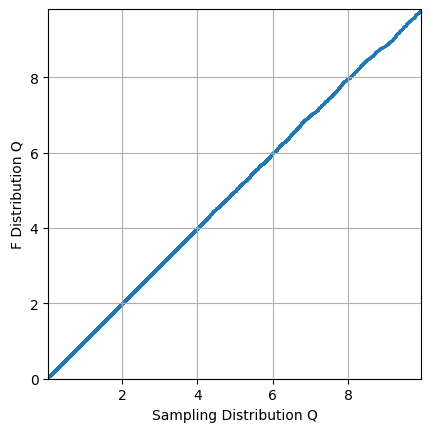

In [62]:
nx, ny = (15, 5)       # Experimental parameters – sample size for each variable
numSims = 50_000       # Number of experiments to simulate
R = np.zeros(numSims)  # Allocate array for each simulation's statistic value
for i in range(numSims):
    # Simulated experiment under H0:
    x = np.random.normal(size=nx)  # Default scale parameter is 1; under H0 we only
    y = np.random.normal(size=ny)  #  require that it is the same for both variables.
    varX = np.var(x, ddof=1)
    varY = np.var(y, ddof=1)
    R[i] = varX/varY   # The test statistic for this simulation
R.sort()  # Now sorted, R[] is the sampling distribution of the test statistic

# Prepare Q-Q plot to compare sampling distribution with the F distribution
r = np.linspace(0, 1, numSims, endpoint=False)  # Quantiles
Q = f.ppf(r, nx-1, ny-1)  # Quantile values of the F distribution
cut_tail = int(0.98 * numSims)  # Cut off the extreme right tail where we get a few huge values
plt.scatter(R[:cut_tail], Q[:cut_tail], s=1)
plt.xlabel('Sampling Distribution Q')
plt.ylabel('F Distribution Q')
plt.margins(x=0,y=0)
plt.gca().set_aspect(1)
plt.grid(True)
plt.show()

So that confirms that the sampling distribution matches the formulaic distribution.

Now let's look at how to use the distribution (either one) to calculate the *p* value and confidence interval for this question.

## CI and *p* for one experiment

The *p* value comes directly from the distribution that models the statistic.  The formula to compute a confidence interval takes a little more work:

The formula for the Confidence Interval on a ratio of sample variances, for Normal variables, is:

$$\frac{s_x^2}{s_y^2} \ \times \left[ \frac{1}{F_{\frac{1+\gamma}{2}}(n_x-1, n_y-1)}, \frac{1}{F_{\frac{1-\gamma}{2}}(n_x-1, n_y-1)} \right]$$

The following code simulates one experiment and then shows how to compute both the *p* value and the CI using both the formulaic and the sampling distributions.  We will compute a two-tailed *p* value because the question we are addressing is whether the variances are *different*, and we want that to include not only scenarios where $s_x^2 > s_y^2$ (which would make the test statistic > 1) but also where $s_x^2 < s_y^2$ (which would make the test statistic < 1).  If we only cared about one of those variants we could exclude the *p* on the other side.  In this case we compute the tails separately because this test statistic can become quite asymmetric when $n_x$ is different from $n_y$.  (When distributions are symmetric we can get a two-tailed value by just doubling the value from one tail.)

In [38]:
true_param = 1  # Simulation setting: True value of VarX/VarY
gamma = 0.9     # Confidence level to compute

# Run Experiment
x = np.random.normal(size=nx, scale=np.sqrt(true_param))
y = np.random.normal(size=ny)
varX = np.var(x, ddof=1)
varY = np.var(y, ddof=1)
ratio = varX/varY

# Right tail of p value
p_right_from_sampling = 1-percentileofscore(R, ratio if ratio >= 1 else 1/ratio)/100
p_right_from_F = 1-f.cdf(ratio if ratio >= 1 else 1/ratio, nx-1, ny-1)
# Left tail of p value
p_left_from_sampling = percentileofscore(R, ratio if ratio <= 1 else 1/ratio)/100
p_left_from_F = f.cdf(ratio if ratio <= 1 else 1/ratio, nx-1, ny-1)

# Compute confidence interval using F-distribution
CU = ratio / f.ppf((1-gamma)/2, nx-1, ny-1)  # Upper bound of confidence interval
CL = ratio / f.ppf((1+gamma)/2, nx-1, ny-1)  # Lower bound of confidence interval
# Compute confidence interval using sampling distribution
CUs = ratio / R[int(numSims * (1-gamma)/2)]  # Upper bound of confidence interval
CLs = ratio / R[int(numSims * (1+gamma)/2)]  # Lower bound of confidence interval

print(f'Samples VarianceX: {varX:.2f} (n={nx})\t VarianceY: {varY:.2f} (n={ny})\n'
      f'\tSample Variance Ratio: {varX/varY:.2f}\t(True Ratio: {true_param})\n'
      f'{gamma:.0%} Confidence Interval on Sample Ratio: [{CL:.2f}, {CU:.2f}] from F-dist\n'
      f'\t\t ... Confidence Interval [{CLs:.2f}, {CUs:.2f}] from sampling distribution\n'
      f'\t p value from sampling = {p_left_from_sampling+p_right_from_sampling:.1%}\n'
      f'\t p value from F distribution = {p_left_from_F+p_right_from_F:.1%}')

Samples VarianceX: 0.70 (n=15)	 VarianceY: 2.35 (n=5)
	Sample Variance Ratio: 0.30	(True Ratio: 1)
90% Confidence Interval on Sample Ratio: [0.05, 0.92] from F-dist
		 ... Confidence Interval [0.05, 0.92] from sampling distribution
	 p value from sampling = 16.5%
	 p value from F distribution = 16.4%


As expected, we get virtually the same statistics whether we use the formula or the sampling distribution.  (Why not *exactly* the same?  In this case, with the sampling distribution based on 50,000 simulations, we may see a difference in the third order.  We can get the numbers to match to an arbitrary precision by increasing the number of simulations used to create the sampling distribution.  In other words, the sampling distribution converges to match the formulaic distribution as the number of simulations increases.)

### Simulation to verify *p*

How can we be sure that our statistical formulas and code are correct?

We'll go right back to the definition of the *p* value: *The probability of observing a test statistic that is at least as extreme as the one observed in the experiment when $H_0$ is true.*

Remember: If the null hypothesis $H_0$ is true then *X* and *Y* have the same distribution.  In this experiment we drew $n_x$ samples from *X* and $n_y$ samples from *Y* and then computed the test statistic (the ratio of their sample variances).  So to verify the *p* value we calculated above: we'll simulate a large number of such experiments with *X* and *Y* drawing from the same distribution and **count how many of the experiments give a test statistic that is at least as extreme as the one for which we computed the *p* value** above.  By definition, that proportion should match the calculated *p* value.

Recall that for this example we computed a two-tailed value because we are looking for a difference in either direction.  So if one variance is twice as large as the other, then the ratio could be either 2/1 or 1/2, and if it's the former than "more extreme" means greater than 2, and if it's the latter than "more extreme" means less than 1/2.  To handle both tails, for each simulation we will check both the ratio and its inverse.

In [42]:
print(f'For the experimental variance ratio {ratio:.2f} and its inverse {1/ratio:.2f}:')
print(f'\tF-dist gives p left tail = {p_left_from_F:.1%}, right tail = {p_right_from_F:.1%},'
      f' sum={p_right_from_F+p_left_from_F:.1%}')
sample_ratio = ratio  # Ratio from single experiment above
if sample_ratio < 1:  # Reference value will be the ratio in terms > 1
    sample_ratio = 1/sample_ratio
count_left = 0
count_right = 0
for i in range(numSims):
    x = np.random.normal(size=nx)  # We're using the same distribution for both variables
    y = np.random.normal(size=ny)  # since this is a simulation under the null hypothesis
    simVarX = np.var(x, ddof=1)
    simVarY = np.var(y, ddof=1)
    simRatio = simVarX/simVarY
    if simRatio > 1 and simRatio >= sample_ratio:
        count_right += 1
    elif simRatio < 1 and simRatio <= 1/sample_ratio:
        count_left += 1
print(f'Over {numSims:,} simulations with (nx={nx}, ny={ny}) using the null hypothesis:\n'
      f'\t{count_left/numSims:5.1%} produced a variance ratio < {1/sample_ratio:.2f}\n'
      f'\t{count_right/numSims:5.1%} produced a variance ratio > {sample_ratio:.2f}\n'
      f'\t{(count_left+count_right)/numSims:.1%} produced a statistic more extreme than the experiment.')

For the experimental variance ratio 0.30 and its inverse 3.37:
	F-dist gives p left tail = 4.0%, right tail = 12.5%, sum=16.4%
Over 50,000 simulations with (nx=15, ny=5) using the null hypothesis:
	 4.0% produced a variance ratio < 0.30
	12.5% produced a variance ratio > 3.37
	16.4% produced a statistic more extreme than the experiment.


As in all probabilistic methods: the simulated results can differ slightly from the formulaic results, but they will converge as the number of simulations increases.  Here, with 50,000 simulations, we see some differences in the third figure.  Increase the number of simulations and those differences will disappear.

### Simulation to verify CI formula
We'll use the same method to verify the Confidence Interval (CI) formula.

By definition, the Confidence Interval is *a range that contains the true parameter in exactly $\gamma$ (gamma) proportion of the experiments*.  So we'll simulate many experiments, calculate the CI each time, and **count how many of the CIs contain the true parameter**.  (Here we know the true parameter because we are specifying it in the random number generator of the simulation.)

In [12]:
true_param = 3  # True parameter VarX/VarY
gamma = 0.9     # Desired confidence level
FU = 1/f.ppf((1-gamma)/2, nx-1, ny-1)  # Upper bound of F dist
FL = 1/f.ppf((1+gamma)/2, nx-1, ny-1)  # Lower bound of F dist
count_contains_true = 0  # Number of simulations in which CI contains true parameter
for i in range(numSims):
    x = np.random.normal(size=nx, scale=np.sqrt(true_param))
    y = np.random.normal(size=ny, scale=1)
    varX = np.var(x, ddof=1)
    varY = np.var(y, ddof=1)
    ratio = varX/varY
    CL = ratio * FL  # Confidence interval lower bound 
    CU = ratio * FU  # Confidence interval upper bound
    if CL < true_param < CU:
        count_contains_true += 1

print(f'Over {numSims:,} simulations of {nx} samples for X and {ny} samples for Y,\n\t'
      f'the {gamma:.0%} CI contained the true parameter {count_contains_true / numSims:.1%} of the time.')

Over 50,000 simulations of 15 samples for X and 5 samples for Y,
	the 90% CI contained the true parameter 90.1% of the time.


# Difference of Means, Normal variables

We want to know whether the mean of two Normally distributed variables is different.  The mean is a location parameter so the test statistic will be the difference of the estimated means.  In the general case this turns out to be tricky:  If *X* and *Y* are Normally distributed, then the normalized difference of their estimated means is t-distributed with $\nu$ (nu) degrees of freedom as follows:

$$\frac{\bar{x} - \bar{y}}{\sqrt{\epsilon_x+\epsilon_y}} \sim t(\nu), \ \text{where:} \ \ \nu=\frac{(\epsilon_x + \epsilon_y)^2}{\frac{\epsilon_x^2}{n_x-1}+\frac{\epsilon_y^2}{n_y-1}}, \ \ \ \epsilon_i = \frac{s_i^2}{n_i}$$

The confidence interval on the estimated difference is:

$$(\bar{x} - \bar{y}) \pm t_{\frac{1-\gamma}{2}, \ \nu} \ \sqrt{\epsilon_x+\epsilon_y}$$

(The formula for $\nu$ is known as the Welch–Satterthwaite equation, and $\nu$ is the *effective degrees of freedom*.  The Welch statistics are not exactly t-distributed, but are close enough for all practical purposes.)

### If variances are the same
We can get tighter confidence intervals if we know that the variance of *X* and *Y* are the same (because we are estimating just one "pooled sample variance" instead of splitting the samples to make two different variance estimates), in which case we can use Student's formulation:
$$(\bar{x} - \bar{y}) \pm t_{\frac{1-\gamma}{2},n_x+n_y-2} \left(S_p \sqrt{\frac{1}{n_x}+\frac{1}{n_y}}\right), \ \text{where:} \ S_p^2 = \frac{(n_x-1)s_x^2+(n_y-1)s_y^2}{n_x+n_y-2}$$

**However:** If this equal-variance assumption is incorrect then the inference will be invalid.  Getting a more significant but erroneous result seems like a bad tradeoff, so *unless you are very confident that variances are equal, use the Welch formulas!*

## CI and *p* for one experiment

In [44]:
# Experimental parameters
nX, nY = (15, 5)        # Sample size for each variable
meanX, meanY = (0, 0.6) # True mean values
sigmaX, sigmaY = (1, 2) # True standard deviations

# One experiment:
x = np.random.normal(size=nX, loc=meanX, scale=sigmaX)
y = np.random.normal(size=nY, loc=meanY, scale=sigmaY)
muX = np.mean(x)          # Sample mean of X
muY = np.mean(y)          # Sample mean of Y
varX = np.var(x, ddof=1)  # Sample variance of X
varY = np.var(y, ddof=1)  # Sample variance of Y
sampleDiff = (muX - muY)
eX = varX / nX
eY = varY / nY
tstat = sampleDiff / np.sqrt(eX+eY)
nu = (eX + eY)**2 / (eX**2 / (nX-1) + eY**2 / (nY-1))
p = 2*t.cdf(-abs(tstat), df=nu)  # 2-tailed p value
WelchCI = t.interval(gamma, df=nu, loc=sampleDiff, scale=np.sqrt(eX+eY))
stp = np.sqrt(((nX-1)*varX + (nY-1)*varY)/(nX+nY-2))  # Student's pooled sample variance
StudentCI = t.interval(gamma, df=(nX+nY-2), loc=sampleDiff, scale=(stp*np.sqrt(1/nX+1/nY)))

print(f'Samples MeanX: {muX:.2f} (n={nX})\t MeanY: {muY:.2f} (n={nY})\n'
      f'\tSample difference of means = {(muX-muY):.2f}\n'
      f'\t p-value={p:.1%} from t-stat: {tstat:.3f}, df={nu:.2f}\n'
      f'{gamma:.0%} Confidence Interval on sample difference of means:\n'
      f'\t  Welch: [{WelchCI[0]:.2f}, {WelchCI[1]:.2f}]\n'
      f'\tStudent: [{StudentCI[0]:.2f}, {StudentCI[1]:.2f}]')

Samples MeanX: 0.07 (n=15)	 MeanY: 0.65 (n=5)
	Sample difference of means = -0.58
	 p-value=58.9% from t-stat: -0.580, df=4.52
90% Confidence Interval on sample difference of means:
	  Welch: [-2.65, 1.48]
	Student: [-1.76, 0.60]


### Simulation to verify *p*

In [46]:
print(f'Experimental difference of means was {(muX-muY):.2f} with p={p:.1%}')
numSims = 50_000  # Number of simulations to run
leftStat = tstat
if leftStat > 0: leftStat = -leftStat
count_left = 0
count_right = 0
for i in range(numSims):
    x = np.random.normal(size=nX)  # We're using the same parameters for both variables
    y = np.random.normal(size=nY)  # since this is a simulation under the null hypothesis
    simMeanX = np.mean(x)
    simMeanY = np.mean(y)
    simVarX = np.var(x, ddof=1)  # Sample variance of X
    simVarY = np.var(y, ddof=1)  # Sample variance of Y
    eX = simVarX / nX
    eY = simVarY / nY
    simStat = (simMeanX - simMeanY) / np.sqrt(eX+eY)
    if simStat > 0 and simStat >= -leftStat:
        count_right += 1
    elif simStat < 0 and simStat <= leftStat:
        count_left += 1
print(f'Over {numSims:,} simulations with (nx={nX}, ny={nY}) under the null hypothesis:\n'
      f'\t{count_left/numSims:5.1%} produced a test statistic < {leftStat:.2f}\n'
      f'\t{count_right/numSims:5.1%} produced a test statistic >  {-leftStat:.2f}\n'
      f'\t{(count_left+count_right)/numSims:.1%} produced a statistic more extreme than the experiment.')

Experimental difference of means was -0.58 with p=58.9%


Over 50,000 simulations with (nx=15, ny=5) under the null hypothesis:
	29.2% produced a test statistic < -0.58
	28.8% produced a test statistic >  0.58
	58.0% produced a statistic more extreme than the experiment.


### Simulation to verify CI formula
Here we'll calculate both Welch's and Student's confidence intervals.  Remember: Student's formulas are only valid if the two variables have identical variance (i.e., `sigmaX=sigmaY`).

In [48]:
sampleDiff = np.zeros(numSims)    # The test statistic: sample (meanX-meanY)
WelchWidth = np.zeros(numSims)    # Width of Welch's confidence interval
count_Welch_contains_true = 0     # Simulations in which Welch's CI contains the true statistic
StudentWidth = np.zeros(numSims)  # Width of Student's confidence interval
count_Student_contains_true = 0   # Simulations in which Student's CI contains true statistic
for i in range(numSims):
    x = np.random.normal(size=nX, loc=meanX, scale=sigmaX)
    y = np.random.normal(size=nY, loc=meanY, scale=sigmaY)
    muX = np.mean(x)
    muY = np.mean(y)
    varX = np.var(x, ddof=1)
    varY = np.var(y, ddof=1)
    sampleDiff[i] = (muX - muY)
    eX = varX / nX
    eY = varY / nY
    nu = (eX + eY)**2 / (eX**2 / (nX-1) + eY**2 / (nY-1))
    # Welch's CI:
    CI = t.interval(gamma, df=nu, loc=sampleDiff[i], scale=np.sqrt(eX+eY))
    WelchWidth[i] = CI[1] - CI[0]
    if CI[0] < meanX-meanY < CI[1]:
        count_Welch_contains_true += 1
    # Student's CI (assuming sigmaX=sigmaY)
    varP = ((nX-1)*varX + (nY-1)*varY)/(nX+nY-2)  # Pooled sample variance
    CI = t.interval(gamma, df=(nX+nY-2), loc=sampleDiff[i], scale=np.sqrt(varP * (1/nX + 1/nY)))
    StudentWidth[i] = CI[1] - CI[0]
    if CI[0] < meanX-meanY < CI[1]:
        count_Student_contains_true += 1

print(f'Over {numSims:,} simulations of {nX} samples for X and {nY} samples for Y,\n'
      f'\t\twith sigmaX={sigmaX}, sigmaY={sigmaY} ... i.e., {"equal" if (sigmaX==sigmaY) else "**unequal**"} variances\n'
      f'\tAvg of difference of sample means (muX - muY) = {np.mean(sampleDiff):.2f} vs true value {(meanX-meanY)}\n'
      f'\tAvg Welch CI width:   {np.mean(WelchWidth):.3f}\n'
      f'\tAvg Student CI width: {np.mean(StudentWidth):.3f}\n'
      f'\tand the {gamma:.0%} confidence interval contained the true parameter:\n'
      f'\t\t{count_Welch_contains_true / numSims:.1%} of the time for Welch CI\n'
      f'\t\t{count_Student_contains_true / numSims:.1%} of the time for Student CI')

Over 50,000 simulations of 15 samples for X and 5 samples for Y,
		with sigmaX=1, sigmaY=2 ... i.e., **unequal** variances
	Avg of difference of sample means (muX - muY) = -0.60 vs true value -0.6
	Avg Welch CI width:   3.608
	Avg Student CI width: 2.268
	and the 90% confidence interval contained the true parameter:
		89.3% of the time for Welch CI
		76.1% of the time for Student CI


# Ratio of Sigmas

We want to know whether the precision of two gun systems is different.

If we believe that $\sigma_x \approx \sigma_y$ then we can model the dispersion of shots with the Rayleigh distribution.  We also know that the Rayleigh parameter $\sigma$ is effectively a standard deviation, $\sigma^2$ is a variance, and we saw that a ratio of variances is modelled by the F distribution.  Indeed, for two Rayleigh estimates we have the test statistic:
$$\left(\frac{\hat{\sigma_a}}{\hat{\sigma_b}} \right)^2 \sim F(2n_a, 2n_b)$$

However, the coordinates of shots on a target aren't Rayleigh distributed until we know their center.  And though we like to think that with a properly zeroed gun the Point of Aim is the true center, we know that in general there is always some zero error.  So for each group we have to estimate the center as the mean value of the *x-* and *y-* coordinates, and then compute the sample radii as $r_i = \sqrt{(x_i-\bar{x})^2+(y_i-\bar{y})^2}$, and then those sample radii are Rayleigh distributed.

If $A, B$ are Rayleigh distributed, and to compute the sample radii we have to estimate $g$ group centers, then the test statistic for a difference is the unbiased ratio of mean radii squared, which is distributed as:
$$\left(\frac{\hat{\sigma_a}}{\hat{\sigma_b}} \cdot \frac{c_{G_b}}{c_{G_a}}\right)^2 = \frac{(n_b-g_b) \sum a^2}{(n_a-g_a) \sum b^2} \sim F(2(n_a-g_a), 2(n_b-g_b))$$

(Shown on the left-hand side are two different formulas for the test statistic: We can work backwards from the sigma estimates by removing the $c_G$ correction terms and squaring.  Or we can adjust the mean of sample radii squared by the degrees of freedom.)

The confidence interval on the test is:
$$\left(\frac{\hat{\sigma_a}}{\hat{\sigma_b}} \cdot \frac{c_{G_b}}{c_{G_a}}\right) \ \times \left[\frac{1}{\sqrt{F_{\frac{1+\gamma}{2}}(2(n_a-g_a), 2(n_b-g_b))}}, \frac{1}{\sqrt{F_{\frac{1-\gamma}{2}}(2(n_a-g_a), 2(n_b-g_b))}} \right]$$

(Note: If $n_a=n_b$ then the correction terms $c_G$ cancel and can be omitted.  If the sample sizes are large then the correction terms are negligible – see [the $c_G(n)$ values above](#estimating-standard-deviation-sd).)

## CI and *p* for one experiment

In [84]:
nA, nB = (10, 3)  # Experimental parameters – shots per group
gA, gB = (1, 2)   # Experimental parameters - # of groups
true_param = 1.5    # True parameter: sigmaA/sigmaB
gamma = 0.9   # Confidence level for Confidence Intervals

def groupSumR2(shots: list[tuple[float, float]]) -> float:
    """Given a list of shot coordinates [x,y], return sample sum squared radius"""
    n = len(shots)
    sumR2 = xbar = ybar = 0
    for i in range(n):
        xbar += shots[i, 0]
        ybar += shots[i, 1]
    xbar /= n
    ybar /= n
    for i in range(n):
        sumR2 += (shots[i, 0] - xbar)**2 + (shots[i, 1] - ybar)**2
    return sumR2

def sigmaEstimate(g: int, n: int, groups: list[list[tuple[float, float]]]) -> tuple[float, float, float]:
    """Given g groups of n shots per group,
        return (aggregated estimate of sigma, sum sample radius squared, cG)"""
    sumR2 = 0
    degrees = 2*(n-1)*g
    cG = cGauss(degrees+1)
    for group in range(g):
        sumR2 += groupSumR2(groups[group])
    estimate = cG * math.sqrt(sumR2 / degrees)
    return estimate, sumR2, cG

shotsA = np.random.normal(scale = true_param, size=(gA, nA, 2))
shotsB = np.random.normal(scale = 1, size=(gB, nB, 2))
sigmaA, sumR2A, cG_A = sigmaEstimate(gA, nA, shotsA)
sigmaB, sumR2B, cG_B = sigmaEstimate(gB, nB, shotsB)

A2 = sumR2A/(gA*nA-gA)  # Unbiased mean value of A^2
B2 = sumR2B/(gB*nB-gB)  # Unbiased mean value of B^2
R2Ratio = A2/B2
p_left = f.cdf(R2Ratio if R2Ratio <= 1 else 1/R2Ratio, 2*gA*(nA-1), 2*gB*(nB-1))
p_right = 1-f.cdf(R2Ratio if R2Ratio >= 1 else 1/R2Ratio, 2*gA*(nA-1), 2*gB*(nB-1))

sigmaRatio = sigmaA/sigmaB
cRatio = cG_B/cG_A
root_statistic = sigmaRatio*cRatio
CU = root_statistic/math.sqrt(f.ppf((1-gamma)/2, 2*gA*(nA-1), 2*gB*(nB-1)))  # Upper bound of confidence interval
CL = root_statistic/math.sqrt(f.ppf((1+gamma)/2, 2*gA*(nA-1), 2*gB*(nB-1)))  # Lower bound of confidence interval

print(f'Samples sigmaA: {sigmaA:.2f} (n={gA}x{nA})\t sigmaB: {sigmaB:.2f} (n={gB}x{nB})\n'
      f'\tSample Sigma Ratio: {sigmaRatio:.2f}\t(True Ratio: {true_param})\n'
      f'\tSample Ratio Squared: {R2Ratio:.2f}\n'
      f'{gamma:.0%} Confidence Interval on Sample Ratio: [{CL:.2f}, {CU:.2f}]\n'
      f'\t p left={p_left:.1%}, p right={p_right:.1%}, p value={p_left+p_right:.1%}')

Samples sigmaA: 1.43 (n=1x10)	 sigmaB: 1.04 (n=2x3)
	Sample Sigma Ratio: 1.37	(True Ratio: 1.5)
	Sample Ratio Squared: 1.95
90% Confidence Interval on Sample Ratio: [0.78, 2.21]
	 p left=11.4%, p right=16.9%, p value=28.3%


### Simulation to verify *p*

In [86]:
numSims = 50_000
print(f'For the experimental sigma ratio {sigmaRatio:.2f} and its inverse {1/sigmaRatio:.2f}:')
print(f'\tthe unbiased squared ratio is {R2Ratio:.2f} and its inverse {1/R2Ratio:.2f}:')
print(f'\tF-dist gives p left tail = {p_left:.1%}, right tail = {p_right:.1%},'
      f' sum={p_right+p_left:.1%}')
sample_ratio = R2Ratio  # Ratio from single experiment above
if sample_ratio < 1:  # Reference value will be the ratio in terms > 1
    sample_ratio = 1/sample_ratio
count_left = 0
count_right = 0
for i in range(numSims):
    samplesA = np.random.normal(size=(gA, nA, 2))  # We're using the same distribution for both variables
    samplesB = np.random.normal(size=(gB, nB, 2))  # since this is a simulation under the null hypothesis
    simSigmaA, simSumR2A, sim_cG_A = sigmaEstimate(gA, nA, samplesA)
    simSigmaB, simSumR2B, sim_cG_B = sigmaEstimate(gB, nB, samplesB)
    simR2Ratio = ((simSigmaA*sim_cG_B)/(simSigmaB*sim_cG_A))**2
    # Alternate formula for test statistic:
    # A2 = simSumR2A/(gA*nA-gA)
    # B2 = simSumR2B/(gB*nB-gB)
    # simR2Ratio = A2/B2
    if simR2Ratio > 1 and simR2Ratio >= sample_ratio:
        count_right += 1
    elif simR2Ratio < 1 and simR2Ratio <= 1/sample_ratio:
        count_left += 1
print(f'Over {numSims:,} simulations with (nA={gA}x{nA}, nB={gB}x{nB}) using the null hypothesis:\n'
      f'\t{count_left/numSims:5.1%} produced a variance ratio < {1/sample_ratio:.2f}\n'
      f'\t{count_right/numSims:5.1%} produced a variance ratio > {sample_ratio:.2f}\n'
      f'\t{(count_left+count_right)/numSims:.1%} produced a statistic more extreme than the experiment.')

For the experimental sigma ratio 1.37 and its inverse 0.73:
	the unbiased squared ratio is 1.95 and its inverse 0.51:
	F-dist gives p left tail = 11.4%, right tail = 16.9%, sum=28.3%
Over 50,000 simulations with (nA=1x10, nB=2x3) using the null hypothesis:
	11.4% produced a variance ratio < 0.51
	16.9% produced a variance ratio > 1.95
	28.3% produced a statistic more extreme than the experiment.


### Simulation to verify CI formula

In [88]:
numSims = 50_000
nA, nB = (12, 3)  # Experimental parameters – shots per group
gA, gB = (1, 4)   # Experimental parameters - # of groups
true_param = 1.5  # True parameter: sigmaA/sigmaB
gamma = 0.9   # Confidence level for Confidence Intervals

def sigmaRatioExperiment():
    shotsA = np.random.normal(scale = true_param, size=(gA, nA, 2))
    shotsB = np.random.normal(scale = 1, size=(gB, nB, 2))
    sigmaA, _, cG_A = sigmaEstimate(gA, nA, shotsA)
    sigmaB, _, cG_B = sigmaEstimate(gB, nB, shotsB)
    sigmaRatio = sigmaA/sigmaB
    cRatio = cG_B/cG_A
    return sigmaRatio, cRatio

FU = 1/math.sqrt(f.ppf((1-gamma)/2, 2*gA*(nA-1), 2*gB*(nB-1)))  # Upper bound of F dist
FL = 1/math.sqrt(f.ppf((1+gamma)/2, 2*gA*(nA-1), 2*gB*(nB-1)))  # Lower bound of F dist
count_contains_true = 0  # Number of simulations in which CI contains true parameter

for i in range(numSims):
    sampleRatio, cRatio = sigmaRatioExperiment()
    CL = sampleRatio * cRatio * FL
    CU = sampleRatio * cRatio * FU
    if CL < true_param < CU:
        count_contains_true += 1

print(f'Over {numSims:,} simulations with (nA={gA}x{nA}, nB={gB}x{nB}),\n\t'
      f'the {gamma:.0%} CI contained the true parameter {count_contains_true / numSims:.1%} of the time.')

Over 50,000 simulations with (nA=1x12, nB=4x3),
	the 90% CI contained the true parameter 90.2% of the time.
